# Deep Learning for image classification
### Amir, 2025, NUS SoC ACE

#### We'll try to classify images of pets into 2 classes, Cats and Dogs
#### We compute and report the classification accuracy
#### Images are in $ petsmaller$ folder. they are color and 180x180 pixels

In [1]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# mounting the Google drive

# Load the dataset
fp = "sample_data/petsmaller"

In [ ]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
# setting the train and evaluation dataset and directories

In [5]:
image_size = (180, 180)
batch_size = 16
'''
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    fp,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    fp,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

print(train_ds)
print(val_ds)
'''
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    fp,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 104 files belonging to 2 classes.
Using 84 files for training.
Using 20 files for validation.


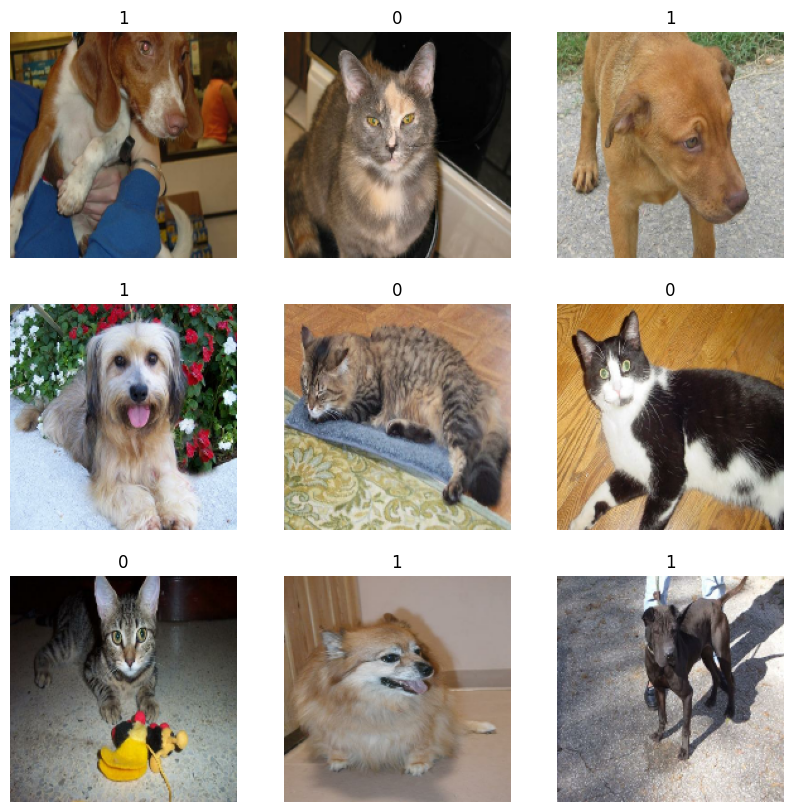

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

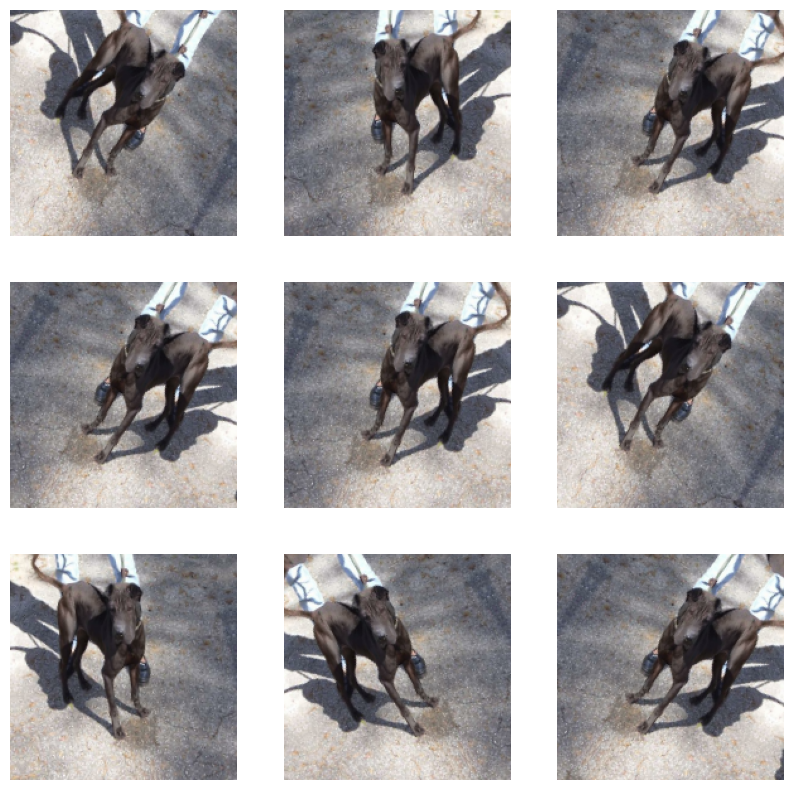

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [15]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
# making our deep model

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [20]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# compiling and training our model

In [ ]:
epochs = 30

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.4859 - loss: 1.0289 - val_accuracy: 0.6000 - val_loss: 0.6899
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.5558 - loss: 0.7079 - val_accuracy: 0.6000 - val_loss: 0.6892
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7095 - loss: 0.6008 - val_accuracy: 0.6000 - val_loss: 0.6866
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.5729 - loss: 0.6945 - val_accuracy: 0.6000 - val_loss: 0.6890
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step - accuracy: 0.6409 - loss: 0.6171 - val_accuracy: 0.6000 - val_loss: 0.6927
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6686 - loss: 0.6237 - val_accuracy: 0.6000 - val_loss: 0.6924
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7278 - loss: 0.5819 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7522 - loss: 0.5121 - val_accuracy: 0.6000 - val_loss: 0.6907
Epoch 9/

In [ ]:
# above: the last validation accuracy above, is a good metric
# to show your classifier performance
# below: testing the classifier with some images

In [ ]:
img = keras.preprocessing.image.load_img( fp+"/Cat/0.jpg" , target_size=image_size )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
img = keras.preprocessing.image.load_img( fp+ "/Dog/4.jpg" , target_size=image_size )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
img = keras.preprocessing.image.load_img( fp+"/Dog/31.jpg", target_size=image_size )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

In [ ]:
#
# the list of test files is in flst.txt, you may need to change the path
# predict() function is employed , each test image is preprocessed the way train images had been
#
fp= "/content/drive/My Drive/emeritus/2025/Module2-3/flst.txt"
# Open and read the file list
with open(fp, "r") as f:
    filenames = f.read().splitlines()  # Read all lines and remove newline characters

# Process each file
predct = []
for i in filenames:
    #i = i.decode('utf-8')
    img = keras.preprocessing.image.load_img( i , target_size=image_size )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = predictions[0]
    print( i ,
        " is %.2f percent cat and %.2f percent dog."
        % (100 * (1 - score), 100 * score)
    )
    predct.append( np.round(score) )


In [ ]:
print('Predictions: ')
for j in range(len (predct)):
  print(predct[j])


##  Practices
1. train the model for 5, 10, and 80 epochs. what are the evaluation results?
2. set back everything to the original setting, then try delete some of the convolutional and downsampling layers and train the model again. What will be the evaluation results?
3. Deep convolutional model used here is a modified Xception (Extreme Inception). Can you change the make_model() function and use other known deep convolutional models like Alexnet or VGG-16? Try that and see the results.

#### points:
- use GPU as your runtime type
